In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vit_b_16

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
df = pd.read_excel('mouse_data.xlsx')
df = df[df['train_or_test'].isin(['train', 'test'])]
df.head()

,file_name,description,train_or_test,frame_recom,best_sos,pos1,pos2,pos3,pos4,pos5
0,20240606140047_Spectrum_mouse_w2_690-750_pos15...,皮下血管清晰,train,0:49:5,1474.0,NaN,NaN,NaN,NaN,NaN
1,20240606153406_Spectrum_mouse_w3_690-750-5-pos...,皮下血管一般,train,0:49:5,1476.0,NaN,NaN,NaN,NaN,NaN
2,20240606154106_Spectrum_mouse_w3_690-750-5-pos...,皮下血管清晰,train,0:49:5,1473.0,NaN,NaN,NaN,NaN,NaN
3,20240606154315_Spectrum_mouse_w3_690-750-5-pos...,皮下血管清晰，与20240606154106相似,test,0:49:5,1474.0,NaN,NaN,NaN,NaN,NaN
4,20240606154520_Spectrum_mouse_w3_690-750-5-pos...,皮下血管一般，与20240606153406相似,test,0:49:5,1476.0,NaN,NaN,NaN,NaN,NaN


In [3]:
npy_list, sos_list = [], []
for file_name in df['file_name']:
    npy_list.append(file_name.split('_', 1)[0] + '.npy')
    sos_list.append(df.loc[df['file_name'] == file_name, 'best_sos'].item())

In [4]:
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.CenterCrop(224),
])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TestNet = vit_b_16().to(device)
TestNet.heads.head = nn.Linear(in_features=768, out_features=2, bias=True).to(device)
TestNet.load_state_dict(torch.load('model/ViTB16.pth'))

<All keys matched successfully>

In [6]:
def find_transitions(tensor):
    if tensor.numel() == 0:
        return []

    tensor = tensor.flatten()
    elements = tensor.tolist()

    if all(x == 0 for x in elements) or all(x == 1 for x in elements):
        return []

    transitions = []
    prev = elements[0]

    for i in range(1, len(elements)):
        current = elements[i]
        if current != prev:
            if 3 < i < 16:
                transitions.append(i)
            prev = current

    return transitions


In [7]:
file_dir = '../data/data_1450_1550_5ms'

def prediction(n):
    file_path = os.path.join(file_dir, npy_list[n])

    dict = np.load(file_path, allow_pickle=True).item()
    images_valid = dict['images']
    images_valid = images_valid.reshape(-1, 20, 250, 250)

    mean = np.mean(images_valid)
    std = np.std(images_valid)
    images_valid = (images_valid - mean) / std

    print(npy_list[n])

    start = time.time()
    with torch.no_grad():
        results = []
        for i in range(images_valid.shape[0]):
            test_imgs = []
            for j in range(20):
                test_img = np.stack([images_valid[i][j]] * 3, axis=-1)
                test_img = valid_transform(test_img)
                test_imgs.append(test_img)
            test_imgs = torch.stack(test_imgs).to(device)
            test_output = TestNet(test_imgs)
            # test_output = net(test_imgs)
            _, predicted = torch.max(test_output, 1)
            results.append(find_transitions(predicted))
    end = time.time()
    # print(end - start)
    # print(results)

    flatten = []
    for result in results:
        if len(result) == 1:
            flatten.extend(result * 3)  # 添加三次
        else:
            flatten.extend(result)  # 直接添加所有元素

    # print(f"SOS Index Mean: {np.mean(flatten):.4f}")
    # print(f"SOS Index Std : {np.std(flatten):.4f}")
    print(f"SOS Prediction: {np.mean(flatten) * 5 + 1450 - 3:.4f}")
    print(f"SOS True      : {sos_list[n]:.4f}")

    return (npy_list[n],
            np.mean(flatten) * 5 + 1450 - 3,
            sos_list[n],
            (end - start) / (images_valid.shape[0] * images_valid.shape[1]))

In [8]:
dict = {
    'name': [],
    'pred': [],
    'true': [],
    'time': []
}

for i in range(len(npy_list)):
    name, pred, true, time_ = prediction(i)
    dict['name'].append(name)
    dict['pred'].append(pred)
    dict['true'].append(true)
    dict['time'].append(time_)

20240606140047.npy
SOS Prediction: 1475.0000
SOS True      : 1474.0000
20240606153406.npy
SOS Prediction: 1475.0000
SOS True      : 1476.0000
20240606154106.npy
SOS Prediction: 1476.5000
SOS True      : 1473.0000
20240606154315.npy
SOS Prediction: 1477.0000
SOS True      : 1474.0000
20240606154520.npy
SOS Prediction: 1476.5000
SOS True      : 1476.0000
20250212134032.npy
SOS Prediction: 1506.6667
SOS True      : 1506.0000
D304.npy
SOS Prediction: 1494.0000
SOS True      : 1497.0000
D1952.npy
SOS Prediction: 1469.5676
SOS True      : 1473.0000
D2503.npy
SOS Prediction: 1477.0000
SOS True      : 1478.0000
D2657.npy
SOS Prediction: 1476.5000
SOS True      : 1474.0000
D2721.npy
SOS Prediction: 1477.5000
SOS True      : 1476.0000
D3100.npy
SOS Prediction: 1478.0000
SOS True      : 1476.0000
D11887.npy
SOS Prediction: 1502.7500
SOS True      : 1503.0000
D11980.npy
SOS Prediction: 1509.5833
SOS True      : 1509.0000
D12305.npy
SOS Prediction: 1505.2500
SOS True      : 1502.0000
D12309.npy
SOS

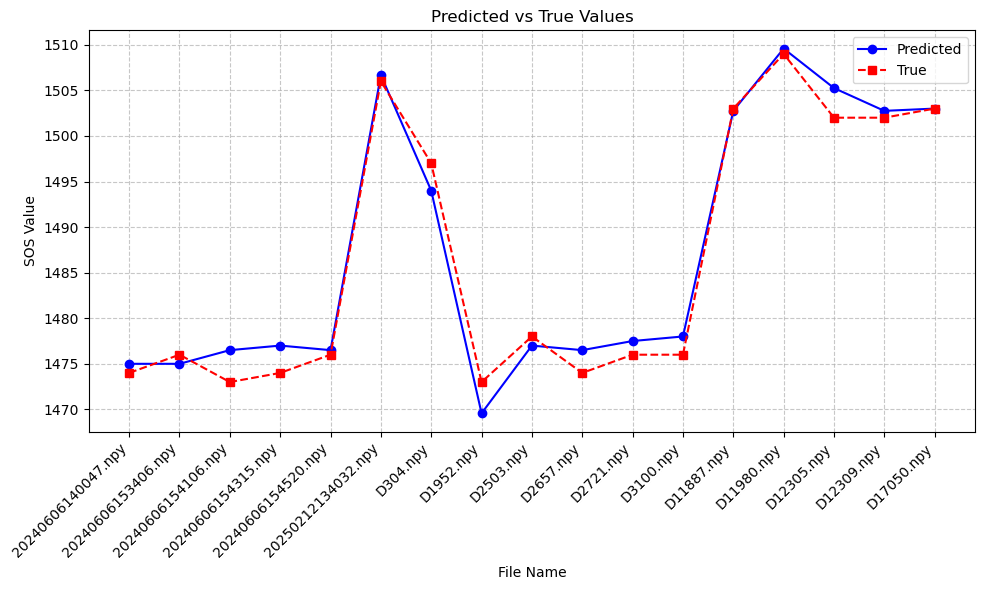

In [9]:
# 设置画布
plt.figure(figsize=(10, 6))

# 绘制折线图
x = np.arange(len(dict['name']))  # x轴位置
plt.plot(x, dict['pred'], marker='o', linestyle='-', color='b', label='Predicted')
plt.plot(x, dict['true'], marker='s', linestyle='--', color='r', label='True')

# 设置坐标轴和标题
plt.xlabel('File Name')
plt.ylabel('SOS Value')
plt.title('Predicted vs True Values')
plt.xticks(x, dict['name'], rotation=45, ha='right')  # 设置x轴标签
plt.legend()  # 显示图例

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [10]:
mae = np.mean(np.abs(np.array(dict['pred']) - np.array(dict['true'])))
max = np.max(np.abs(np.array(dict['pred']) - np.array(dict['true'])))
print(f"Mean Absolute Error: {mae:.4f} m/s")
print(f"Max Absolute Error: {max:.4f} m/s")

mean = np.mean(np.array(dict['time']))
print(f"Mean Time Prediction: {mean:.4f} s")

Mean Absolute Error: 1.6431 m/s
Max Absolute Error: 3.5000 m/s
Mean Time Prediction: 0.0045 s


声速偏小


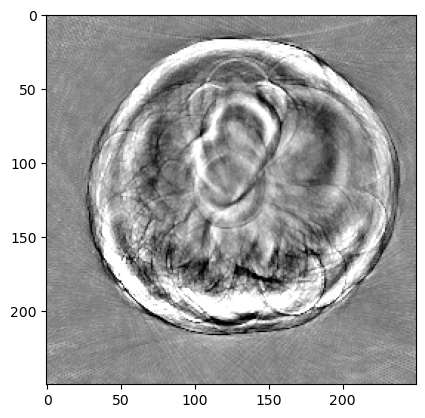

In [11]:
images = np.load("C:/Users/zhangtw/Desktop/mouse_data/data_5ms/D11980.npy")

frame_idx = np.random.randint(0, 40)
sos_values = list(range(0, 12)) + list(range(28, 40))
sos_idx = np.random.choice(sos_values)

test_img = images[frame_idx, sos_idx]
plt.imshow(test_img, cmap='gray', vmin=-6, vmax=6)

with torch.no_grad():
    test_img = np.stack([test_img] * 3, axis=-1)
    test_img = valid_transform(test_img)
    test_output = TestNet(test_img.unsqueeze(0).to(device))
    _, predicted = torch.max(test_output, 1)
    if predicted == 0:
        print("声速偏小")
    if predicted == 1:
        print("声速偏大")